# Transfer learning 101

In this notebook you will learn how to train a custom classifier using transfer learning and deploy the model on a website using GitHub pages in 15 mins.

First you need to decide what classes you want for your classifier. Give them in alphabetical order.

In [1]:
classes = ['cat', 'dog', 'horse'] # Change this

Before proceeding *REMEMBER TO ENABLE GPU IN THE RUNTIME ENVIRONMENT:*
Go to Runtime -> "Change runtime type" and select GPU as hardware acelerator.



**Installing dependicies**

In [2]:
!pip install fastbook --quiet
!pip install tensorflowjs --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.1 MB/s

We will be using a deep learning framework, called [Keras](https://keras.io/). Keras is a high-level neural network API, written in Python and capable of running on top of [TensorFlow](https://www.tensorflow.org/), CNTK, and Theano.

A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network is simply a saved network previously trained on a large dataset, such as the [ImageNet dataset](http://www.image-net.org/) (1.4 million labeled images and 1000 different classes). If this original dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems might involve completely different classes from those of the original task.

You can run the whole notebook now or run them one at a time. Nothing else needs to be changed.



# Mount your Google Drive, create data directory, and download training images

We will need to mount your google drive so we can save the images we need for training. Run the cell below and allow connection to google drive.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Create a directory to store the downloaded images in.

In [4]:
from pathlib import Path
root = '/content/gdrive/My Drive/' # Don't change this
data_dirname = 'data-transfer-learning-101'
p = Path(root + data_dirname)
p.mkdir(exist_ok = True)

Download images from DuckDuckGo. In the example I used 100 images for each class, feel free to change this amount.

In [5]:
from fastbook import *

# Ensure folder is empty by deleting and remaking
!rm -rf "/content/gdrive/My Drive/{data_dirname}"
!mkdir "/content/gdrive/My Drive/{data_dirname}"

# Download images
max_images = 100
count = 0
for idx, category in enumerate(classes):
  print(category)
  folder = category
  dest = p/folder
  dest.mkdir(parents=True, exist_ok=True)
  urls = search_images_ddg(category, max_images=max_images)
  download_images(dest, urls = urls, max_pics=max_images)

cat
dog
horse


Verify dowload worked correctly.

In [6]:
!ls -l "/content/gdrive/My Drive/{data_dirname}"

total 12
drwx------ 2 root root 4096 Sep  8 09:06 cat
drwx------ 2 root root 4096 Sep  8 09:06 dog
drwx------ 2 root root 4096 Sep  8 09:06 horse


Remove files which can't be opened

In [7]:
import cv2
import os
for c in classes:
  print(c)
  filelist = [x for x in (p/c).iterdir() if x.is_file()]
  for f in filelist:
    img = cv2.imread(str(f))
    if img is None:
      print(f'Failed to open {f}. Deleting file')
      os.remove(str(f))

cat
Failed to open /content/gdrive/My Drive/data-transfer-learning-101/cat/f5a3a997-2e5f-4f0a-b49b-efb74b5fe6d3.jpg. Deleting file
Failed to open /content/gdrive/My Drive/data-transfer-learning-101/cat/98d33101-1b8d-4b7d-b2ca-782a3f5f295a.gif. Deleting file
Failed to open /content/gdrive/My Drive/data-transfer-learning-101/cat/8e43a2c2-4e2f-4a7b-9f4d-9cff2d24144e.jpg. Deleting file
dog
Failed to open /content/gdrive/My Drive/data-transfer-learning-101/dog/5e353d97-a106-4714-8807-88bdf7915564.jpg. Deleting file
Failed to open /content/gdrive/My Drive/data-transfer-learning-101/dog/9e3f0c88-765a-4119-8926-6f6ca21425ca.jpg. Deleting file
horse
Failed to open /content/gdrive/My Drive/data-transfer-learning-101/horse/29cde148-99f8-49df-b2db-712adf4d28f1.jpg. Deleting file
Failed to open /content/gdrive/My Drive/data-transfer-learning-101/horse/61d65968-e932-447e-9269-b502425ac25f.jpg. Deleting file


We should in theory verify that the images we downloaded actually represent the classes we chose. You can view the images by running the code below.

```
from IPython.display import display
from PIL import Image as PILImage
import matplotlib.pyplot as plt
from pathlib import Path

# Function to display images in a grid
def display_images_in_grid(image_paths, thumb_size=(100, 100), cols=5):
    plt.figure(figsize=(20, 20))  # You can adjust the figure size to control the grid size
    for i, img_path in enumerate(image_paths):
        img = PILImage.open(img_path)
        img.thumbnail(thumb_size)  # Resize image
        plt.subplot(len(image_paths) // cols + 1, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')  # Hide axes for a cleaner look
    plt.show()

num_images = 5  # Number of images to display in each class
# Display images from each category
for category in classes:
    folder = p/category
    print(f"Category: {category}")
    image_files = folder.ls()  # List all files in the category folder
    
    # Display the images in a grid (smaller size)
    display_images_in_grid(image_files[:num_images], thumb_size=(100, 100), cols=5)  # Adjust size and columns as needed
```



# Image generator

Image generator is a tool which makes loading and preprocessing data easy.

Let's set up an image generator that outputs mini-batches of 8 images:


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
generator = datagen.flow_from_directory(str(p),
                                        target_size=(120,120),
                                        color_mode='rgb',
                                        batch_size=8,
                                        class_mode='categorical',
                                        shuffle=True)

Found 273 images belonging to 3 classes.


**Note:** Check that the classes assigned by the generator are consistent with your class assignment:

In [9]:
print('generator:',generator.class_indices)
print('your\'s:',dict((class_name,class_index) for class_index,class_name in enumerate(classes)))

generator: {'cat': 0, 'dog': 1, 'horse': 2}
your's: {'cat': 0, 'dog': 1, 'horse': 2}


Splitting dataset into a training set and a validation set.

In [10]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)

train_generator = datagen.flow_from_directory(str(p),
                                        target_size=(120,120),
                                        color_mode='rgb',
                                        batch_size=8,
                                        class_mode='categorical',
                                        shuffle=True,
                                        subset='training')
validation_generator = datagen.flow_from_directory(str(p),
                                        target_size=(120,120),
                                        color_mode='rgb',
                                        batch_size=8,
                                        class_mode='categorical',
                                        shuffle=True,
                                        subset='validation')

Found 220 images belonging to 3 classes.
Found 53 images belonging to 3 classes.


# Loading MobileNet for transfer-learning

In our case, we will consider a convolutional neural network (CNN) trained on ImageNet. We will use the MobileNet architecture, but there are other models that you could use as well. Take a look here: https://keras.io/applications

First, let's download and instantiate the pre-trained MobileNet without the top layers (i.e., without the decoder).

You can ignore the warning.

In [11]:
from tensorflow.keras.applications.mobilenet import MobileNet

conv_base = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(120, 120, 3))

<ipython-input-11-6fb272d3f88a>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = MobileNet(weights='imagenet',


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


We will add our own decoder here.

In [12]:
from keras.layers import Dense,GlobalAveragePooling2D
from keras.models import Model

# Add new top layer
N = len(classes)
x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x) # Dense layer
preds = Dense(N, activation='softmax')(x) # Final layer with softmax activation

# Specify model
model = Model(inputs=conv_base.input, outputs=preds)

We will only be training the new dense layers that we added. Disable training for all previous layers and enable for new layers:

In [13]:
total_num_layers = len(model.layers)
num_base_layers = len(conv_base.layers)
print(f"Total number of layers is {total_num_layers}")
print(f"Number of pretrained base layers is {num_base_layers}")

for layer in model.layers[:num_base_layers]:
    layer.trainable=False
for layer in model.layers[num_base_layers:]:
    layer.trainable=True

Total number of layers is 89
Number of pretrained base layers is 86


We are now ready to start training the model using
- Stochastic Gradient Descent (SGD) optimizer
- Loss function will be categorical cross entropy
- Evaluation metric will be accuracy

I use 10 epochs below for training. Feel free to modify.

In [14]:
from tensorflow.keras import optimizers

# Set up optimizer
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=100,
    decay_rate=1e-6)
sgd_optimizer = optimizers.SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)

# Compile model - make it trainable
model.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train model for 10 epochs
history = model.fit(train_generator,
                   validation_data=validation_generator,
                   epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 7/28 ━━━━━━━━━━━━━━━━━━━━ 10s 482ms/step - accuracy: 0.4659 - loss: 1.5811

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 544ms/step - accuracy: 0.5928 - loss: 1.0820 - val_accuracy: 0.8113 - val_loss: 0.5357
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 484ms/step - accuracy: 0.9089 - loss: 0.2124 - val_accuracy: 0.7925 - val_loss: 0.5332
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 553ms/step - accuracy: 0.8954 - loss: 0.2948 - val_accuracy: 0.7925 - val_loss: 0.5322
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 540ms/step - accuracy: 0.9156 - loss: 0.3285 - val_accuracy: 0.7925 - val_loss: 0.5321
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 505ms/step - accuracy: 0.9294 - loss: 0.2209 - val_accuracy: 0.7925 - val_loss: 0.5321
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 517ms/step - accuracy: 0.9084 - loss: 0.3541 - val_accuracy: 0.7925 - val_loss: 0.5321
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 474ms/step - accuracy: 0.9108 - loss: 0.2684 - val_accuracy: 0.7925 - val_loss: 0.5321
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 664ms/step - accuracy: 0.8862 - loss: 0.3115 - val_accuracy: 0.792

We can plot the accuracy as a function of the epoch number. If the validation accuracy stays farily constant it means that training the model further (for more epochs) would most likely *not* improve the performance.

# Using the model

Here is an example on how to use the model on an image. Below we use the 1st image of the 1st class.

File path: /content/gdrive/My Drive/data-transfer-learning-101/cat/11e74d0f-39b9-4ade-954a-5e721546d30e.png


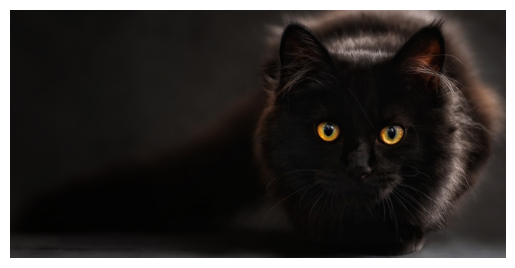

In [15]:
import cv2

# Pick first image of first class
filelist = [x for x in (p/classes[0]).iterdir() if x.is_file()]
img_path = str(filelist[1])
print(f"File path: {img_path}")

# Convert to RGB
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
plt.imshow(img);
plt.axis('off');

Now, make sure that the image shape and the pixel intensity range is as expected by the network (required shape = `1x120x120x3` and intensity range from -1 to 1):

In [16]:
img = cv2.resize(img, (120, 120))
img = (img[...,::-1].astype(np.float32))
img /= 127.5
img -= 1.
img = np.expand_dims(img,0)
print(img.shape,img.min(),img.max())

(1, 120, 120, 3) -1.0 0.9843137


Run the image through the network:

In [17]:
class_probabilities = model.predict(img)[0]
probabilities_with_labels = list(zip(classes, class_probabilities))

# Sort the list by probability in descending order
probabilities_with_labels.sort(key=lambda x: x[1], reverse=True)

# Print the probabilities with formatting
for label, prob in probabilities_with_labels:
    print(f"Probability of {label} is: {100*prob:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
Probability of cat is: 99.92%
Probability of dog is: 0.08%
Probability of horse is: 0.00%


# Deploy the model

We have now traied our model and it's thus ready to be deployed.

## Saving and downloading the model

We will save our model as TensorFlowJS so it can work on GitHub pages.

In [30]:
import tensorflowjs as tfjs
import tensorflow as tf
tf.saved_model.save(model, 'my_model')

# Save model as zip
!zip -r my_model1.zip my_model

# Define the path to your saved model and where you want to save the converted model
saved_model_path = 'my_model'
tfjs_target_dir = 'tfjs_model'
# Convert the model
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model my_model tfjs_model

  adding: my_model/ (stored 0%)
  adding: my_model/assets/ (stored 0%)
  adding: my_model/fingerprint.pb (stored 0%)
  adding: my_model/saved_model.pb (deflated 90%)
  adding: my_model/variables/ (stored 0%)
  adding: my_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: my_model/variables/variables.index (deflated 76%)
2024-09-08 09:22:08.695879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-08 09:22:08.736667: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-08 09:22:08.749170: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-08 09:22:10.5764

In [31]:
import shutil

# Zip the tfjs_model directory
shutil.make_archive('/content/tfjs_model', 'zip', 'tfjs_model')

from google.colab import files

# Download the zip file
files.download('/content/tfjs_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The model can be saved then be uploaded and working again by running the below

```
import tensorflow as tf
tf.saved_model.save(model, 'my_model')

# Save model as zip
!zip -r my_model.zip my_model

# download zipped model
from google.colab import files
files.download('my_model.zip')

# Define the path to the unzipped model directory
model_path = 'my_model/my_model'

# Load the model
loaded_model = tf.saved_model.load(model_path)

# Verify it works
class_probabilities = model.predict(img)[0]
rounded_probabilities = [round(prob, 3) for prob in class_probabilities]
print(rounded_probabilities)
```


## Deploy on GitHub
To make your model into a website like I did [here](https://bjarkehautop.github.io/transfer-learning-101/) you need to do the following:

Make a new repo on your GitHub.

*   Make a new public repo on your GitHub.
*   Unzip your model and upload it to your repo.
*   Copy the styles.css file I have [here](https://github.com/BjarkeHautop/transfer-learning-101/blob/main/styles.css) and add it to your own repo.
*   Copy the index.html file I have [here](https://github.com/BjarkeHautop/transfer-learning-101/blob/main/index.html) and add it to your own repo. Replace every instance of 'Cat', 'Dog' & 'Horse' with your own classes.
*   In your repo go to settings → pages. Under Branch select 'Main'from the dropdown menu and click save.

Wait a minute or so and it tells your website with your classifier is live with a link.

You have now sucessfully trained your custom classifier and deployed it.